In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import import_ipynb
from carga import doCarga
diretorio = '..\\dados\\'
dfNotas = doCarga(diretorio, opcao=3)
dfNotas = dfNotas.drop(columns=['Remetente'])

importing Jupyter notebook from carga.ipynb


In [3]:
# Separa os contadores
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4 = dfNotas['Categoria'].value_counts()

In [4]:
# Divide datasets por classes

df_class_0 = dfNotas[dfNotas['Categoria'] == "31.0simsim"]
df_class_1 = dfNotas[dfNotas['Categoria'] == "38.0simsim"]
df_class_2 = dfNotas[dfNotas['Categoria'] == "38.0simnão"] 
df_class_3 = dfNotas[dfNotas['Categoria'] == "30.0simsim"]         # Tamanho escolhido
df_class_4 = dfNotas[dfNotas['Categoria'] == "31.0nãonão"]         # Classse MUITO pequena - UNDERSAMPLING

# Equipara os tamanhos 30.0simsim que tem 3090 ocorrências
# Foram equiparados ao tamanho da classe 3
MaxSize = 3090 # df_class_3.size 
df_class_0 = df_class_0.sample(MaxSize)
df_class_1 = df_class_1.sample(MaxSize)
df_class_2 = df_class_2.sample(MaxSize)

# Random Oversampling
df_class_4 = df_class_4.sample(MaxSize, replace=True)

# Agrupa novamente
dfAjustado = pd.concat([df_class_0, df_class_1, df_class_2, df_class_3, df_class_4], axis=0)

<AxesSubplot:>

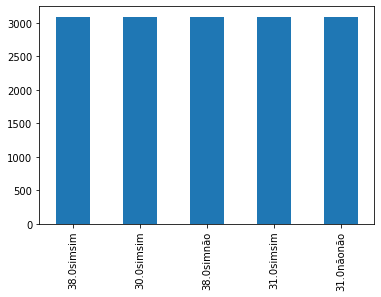

In [5]:
%matplotlib inline
dfAjustado['Categoria'].value_counts().plot.bar()

In [6]:
dfAjustado = dfAjustado.sample(frac=1).reset_index(drop=True)
base_treino = dfAjustado.iloc[:10300,:]
base_teste = dfAjustado.iloc[10301:,:]

#exemplo_base_treino.Categoria.value_counts()
base_teste.shape

(5149, 2)

## Stop Words

In [7]:
lista_Stop = nltk.corpus.stopwords.words('portuguese')
#np.transpose(lista_Stop)

In [8]:
def removeStopWords(texto):
    frases = []
    for (palavras, sentimento) in texto:
        # List Comprehension para pegar palavras fora do lista_Stop
        semStop = [ p for p in palavras.split() if p not in lista_Stop]
        frases.append((semStop, sentimento))
    return frases

## Stemming

In [9]:
def aplica_Stemmer(texto):
    nltk.download('rslp')
    stemmer = nltk.stem.RSLPStemmer()
    frases_sem_Stemming = []
    for ( Categoria, NovaDescricao) in texto:
        com_Stemming = [str(stemmer.stem(p)) for p in NovaDescricao.split() if p not in lista_Stop]
        frases_sem_Stemming.append((com_Stemming, Categoria))
    return frases_sem_Stemming

In [10]:
frases_com_Stem_treinamento = aplica_Stemmer(base_treino.values)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [11]:
pd.DataFrame(frases_com_Stem_treinamento, columns=['Categoria', 'Sentimento']).sample(10)

,Categoria,Sentimento
4457,"[nf, ressarc, conf, dec, 18-df, (ref., 01/2016)]",31.0nãonão
7990,"[cop, desc, copocentr, agu, tran, 180m, abnt, ...",31.0nãonão
4549,"[chopp, vinh, grap, cool]",31.0nãonão
7186,"[cervej, lt, proib]",31.0nãonão
5499,"[cervej, lt, proib, pur, malt]",31.0nãonão
4847,"[sha, j-jbaby, cab, escur, prot, uv]",38.0simnão
5888,"[cp, sh, niely, reconst, profund]",38.0simnão
3629,"[cop, desc, copocentr, ag, abnt, 100u, cx/0025]",31.0nãonão
5932,"[edt, joop, homm, wild, vap]",38.0simsim
4172,"[chour, tradic, carn, vinh, prim]",31.0nãonão


In [12]:
frases_com_Stem_teste = aplica_Stemmer(base_teste.values)

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\svpon\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [13]:
def busca_Palavras(frases):
    todas_Palavras = []
    for (palavras, Categoria) in frases:
        todas_Palavras.extend(palavras)
    return todas_Palavras

In [14]:
palavras_treinamento = busca_Palavras(frases_com_Stem_treinamento)
palavras_teste = busca_Palavras(frases_com_Stem_teste)

In [15]:
print ('Quantidade de palavras no treinamento {}'.format(pd.DataFrame(palavras_treinamento).count()))

Quantidade de palavras no treinamento 0    47791
dtype: int64


In [16]:
def busca_frequencia(palavras):
    palavras = nltk.FreqDist(palavras)
    return palavras

In [17]:
frequencia_treinamento = busca_frequencia(palavras_treinamento)

In [18]:
frequencia_treinamento.most_common(20)

[('sh', 1019),
 ('cachac', 968),
 ('esm', 783),
 ('beb', 453),
 ('conf', 442),
 ('kit', 427),
 ('gf', 369),
 ('aguard', 359),
 ('6x1', 336),
 ('tto', 323),
 ('1.', 323),
 ('nf', 317),
 ('icm', 315),
 ('dec', 307),
 ('ressarc', 304),
 ('vinh', 304),
 ('cervej', 295),
 ('bl', 256),
 ('skol', 219),
 ('lt', 215)]

In [19]:
frequencia_teste = busca_frequencia(palavras_teste)

In [20]:
def busca_palavras_unicas(frequencia):
    freq = frequencia.keys()
    return freq

palavras_unicas_treinamento = busca_palavras_unicas(frequencia_treinamento)
palavras_unicas_teste = busca_palavras_unicas(frequencia_teste)

In [21]:
def extrator_palavras(documento):
    doc = set(documento)
    caracteristicas = {}
    for palavras in palavras_unicas_treinamento:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [22]:
def extrator_palavras_teste(documento):
    doc = set(documento)
    caracteristicas = {}
    for palavras in palavras_unicas_teste:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [23]:
base_completa_treinamento = nltk.classify.apply_features(extrator_palavras, frases_com_Stem_treinamento)
base_completa_teste = nltk.classify.apply_features(extrator_palavras_teste, frases_com_Stem_teste)

# Naives

In [24]:
classificador = nltk.NaiveBayesClassifier.train(base_completa_treinamento)

In [26]:
print(classificador.labels())

['38.0simnão', '31.0simsim', '30.0simsim', '31.0nãonão', '38.0simsim']


In [28]:
print(classificador.show_most_informative_features(10))

Most Informative Features
                      sh = True           38.0si : 38.0si =    406.4 : 1.0
                  aguard = True           30.0si : 31.0si =    238.5 : 1.0
                    vinh = True           31.0si : 38.0si =    140.2 : 1.0
                     edt = True           38.0si : 31.0si =    108.7 : 1.0
                     art = True           31.0nã : 38.0si =    107.6 : 1.0
                      bl = True           38.0si : 31.0si =    100.9 : 1.0
                    prat = True           30.0si : 38.0si =     82.2 : 1.0
                      ag = True           30.0si : 38.0si =     78.2 : 1.0
                     cop = True           31.0nã : 31.0si =     73.1 : 1.0
                      lt = True           31.0nã : 38.0si =     69.8 : 1.0
None


In [29]:
print (nltk.classify.accuracy(classificador, base_completa_teste))

0.9704797047970479


In [30]:
erros = []
for (frase, Categoria) in base_completa_teste:
    resultado = classificador.classify(frase)
    if resultado != Categoria:
        erros.append((Categoria, resultado, frase))

In [ ]:
from nltk.metrics import ConfusionMatrix
esperado = []
previsto = []
for (frase, Categoria) in base_completa_teste:
    resultado = classificador.classify(frase)
    previsto.append(resultado)
    esperado.append(Categoria)

matriz = ConfusionMatrix(esperado, previsto)
print (matriz)

In [ ]:
teste = 'Bebida láctea chocolate'
#teste = 'amaciante de roupas'
#teste = 'sabão em pó'
testeStemming = []
stemmer = nltk.RSLPStemmer()
for (palavras_treinamento) in teste.split():
    comStem = [p for p in palavras_treinamento.split()]
    testeStemming.append(str(stemmer.stem(comStem[0])))

novo = extrator_palavras(testeStemming)

distribuicao = classificador.prob_classify(novo)
for classe in distribuicao.samples():
    print('%s: %f' % (classe, distribuicao.prob(classe)))

# MULTI

In [ ]:
from nltk.classify.scikitlearn import SklearnClassifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

In [ ]:
# base_treino                          >> pands.core.frame.DataFrame
#lixo = base_treino.to_numpy()        #>> numpy.ndarray
#lixo = base_treino.values            #>> numpy.ndarray
#lixo = base_treino.values.tolist()   #>> list
#lixo = base_treino.iteritems()         #>> generator
type(base_completa_treinamento)

In [ ]:
lixo = base_treino.to_numpy() 
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(base_completa_treinamento)
print("MultinomialNB accuracy percent:", nltk.classify.accuracy(MNB_classifier, base_teste))

In [ ]:
BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(base_completa_treinamento)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, base_teste))